<a href="https://www.kaggle.com/code/babydriver1233/asnr-on-lumbar-spine-degenerative-conditions?scriptVersionId=188050236" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## RSNA-ASNR on lumbar spine degenerative conditions. 

Global Impact: Low back pain is the leading cause of disability worldwide, affecting 619 million people in 2020.
Prevalence: Most people experience low back pain, with its frequency increasing with age.
Conditions: Pain and restricted mobility are often due to spondylosis, which includes degeneration of intervertebral discs and narrowing of the spinal canal, subarticular recesses, or neural foramen.
Diagnosis: MRI provides detailed images of the lumbar spine, helping radiologists diagnose and assess the severity of these conditions.
Treatment: Proper diagnosis and grading of lumbar spine conditions guide treatment and potential surgery to alleviate pain and improve patient quality of life.



<figure>
        <img src="https://files.miamineurosciencecenter.com/media/filer_public_thumbnails/filer_public/51/c6/51c6ffa1-0ea5-48e4-a3a8-dbf81022dbe4/regions_of_the_spine.jpg__1331.0x1109.0_q85_subject_location-665%2C558_subsampling-2.jpg" alt ="Audio Art" style='width:800px;height:500px;'>
        <figcaption>



Herniation Zones

Herniated and Bulging discs can also be classified by the area of the disc they protrude into (herniation zone).

    Central: When the disc extrudes into in the spinal cord.
    Subarticular (Lateral Recess or Paracentral): When the disc extrudes between the spinal cord and the foramen (the space through which the nerves exit the spinal canal).
    Foraminal (Lateral): Disc extrusion into the foramen.
            
            
<figure>
        <img src="https://files.miamineurosciencecenter.com/media/filer_public_thumbnails/filer_public/d5/08/d508ae6a-a4f2-4796-be9f-455f8df45fe1/herniation_zones.jpg__1700.0x1308.0_q85_subject_location-850%2C656_subsampling-2.jpg" alt ="Audio Art" style='width:800px;height:500px;'>
        <figcaption>            
    


## Loading Diagnosis Information

In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import hashlib
import pickle

In [2]:
# Load the train labels
train_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
label_coords_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
series_desc_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

### Merge the severity information from train_df into label_coords_df

In [3]:
label_coords_df = pd.merge(label_coords_df, train_df, on='study_id')

### Check the columns of the merged DataFrame

In [4]:
print(label_coords_df.columns)

Index(['study_id', 'series_id', 'instance_number', 'condition', 'level', 'x',
       'y', 'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3',
       'spinal_canal_stenosis_l3_l4', 'spinal_canal_stenosis_l4_l5',
       'spinal_canal_stenosis_l5_s1', 'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticula

## Function to show sample images

#### A function to display sample images using pydicom is defined.

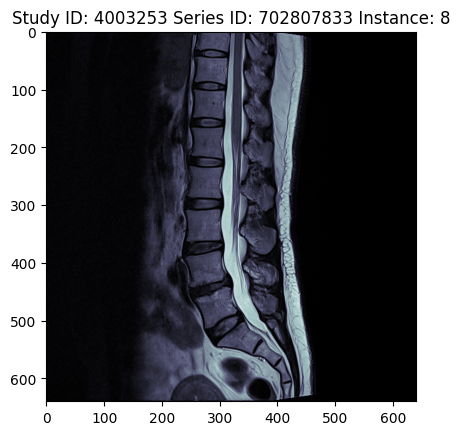

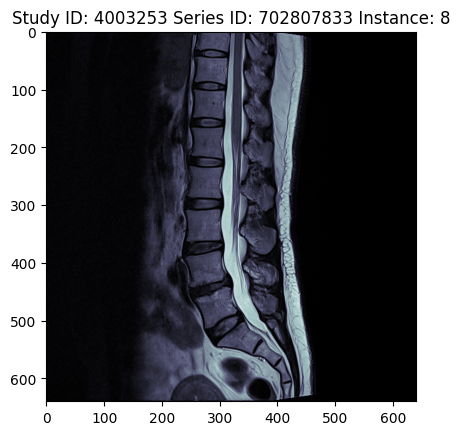

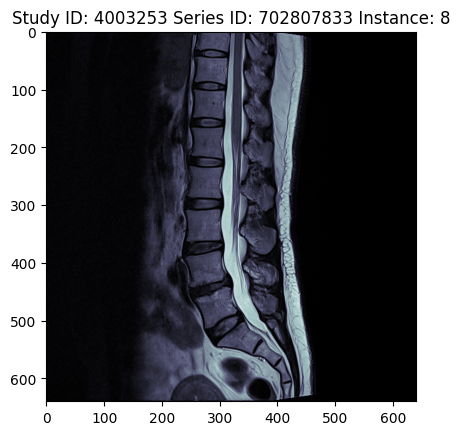

In [5]:
def show_sample_image(study_id, series_id, instance_number):
    img_path = f'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{study_id}/{series_id}/{instance_number}.dcm'
    ds = pydicom.dcmread(img_path)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.title(f'Study ID: {study_id} Series ID: {series_id} Instance: {instance_number}')
    plt.show()

for idx in range(3):
    row = label_coords_df.iloc[idx]
    show_sample_image(row['study_id'], row['series_id'], row['instance_number'])


## Function to create row_id

In [6]:
def create_row_id(study_id, condition, level):
    return f"{study_id}_{condition}_{level}"

## Use a smaller subset of the data for testing

In [7]:
sampled_label_coords_df = label_coords_df.sample(n=1000, random_state=42)
train_df, val_df = train_test_split(sampled_label_coords_df, test_size=0.2, random_state=42)

## Data Transformations and DataLoader

#### Data Transformations and DataLoader with Data Augmentation.

In [8]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Cache directory

In [ ]:
#CACHE_DIR = '/kaggle/working/cache/'

#def get_cache_path(img_path):
#    hash_key = hashlib.md5(img_path.encode()).hexdigest()
#    return os.path.join(CACHE_DIR, f"{hash_key}.pkl")

#def cache_data(img_path, data):
#    os.makedirs(CACHE_DIR, exist_ok=True)
#    cache_path = get_cache_path(img_path)
#    with open(cache_path, 'wb') as f:
#        pickle.dump(data, f)

#def load_cached_data(img_path):
#    cache_path = get_cache_path(img_path)
#    if os.path.exists(cache_path):
#        with open(cache_path, 'rb') as f:
#            return pickle.load(f)
#    return None

## Custom Dataset Class

#### A custom PyTorch Dataset class is created to handle the dataset. This class reads the DICOM images and their corresponding labels, applies transformations, and returns the images and labels in a format suitable for model training.

In [9]:
class SpineDataset(Dataset):
    def __init__(self, df, img_dir, condition_col, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.condition_col = condition_col
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.df['encoded_label'] = self.label_encoder.fit_transform(self.df[self.condition_col])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm")
        
        cached_data = load_cached_data(img_path)
        if cached_data is not None:
            image, label = cached_data
        else:
            ds = pydicom.dcmread(img_path)
            image = ds.pixel_array
            image = np.stack((image,)*3, axis=-1)
            image = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)
            label = row['encoded_label']
            cache_data(img_path, (image, label))

        if self.transform:
            image = self.transform(image)

        return image, label

### Use one condition column for training, e.g., 'spinal_canal_stenosis_l1_l2'

In [10]:
condition_col = 'spinal_canal_stenosis_l1_l2'

### Create train and validation datasets

In [11]:
train_dataset = SpineDataset(train_df, '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images', condition_col, transform=transform_train)
val_dataset = SpineDataset(val_df, '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images', condition_col, transform=transform_val)

### Create DataLoaders

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

## Define and Train the CNN Model

#### Define a convolutional neural network (CNN) model using a pretrained ResNet-18 architecture.

#### Load pretrained weights if available.

In [13]:
class SpineCNN(nn.Module):
    def __init__(self):
        super(SpineCNN, self).__init__()
        self.model = models.resnet18(weights=None)  # Do not use pre-trained weights
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout regularization
            nn.Linear(self.model.fc.in_features, 3)
        )

    def forward(self, x):
        return self.model(x)

model = SpineCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SpineCNN(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Training the Model

#### Define a function to train the model, specifying the loss function (CrossEntropyLoss) and optimizer (Adam). The training and validation losses are plotted.

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses = []
    val_losses = []
    early_stopping_patience = 5
    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15)

  0%|          | 0/25 [00:00<?, ?it/s]


NameError: Caught NameError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_101/3392736835.py", line 17, in __getitem__
    cached_data = load_cached_data(img_path)
NameError: name 'load_cached_data' is not defined


### Load the best model

In [ ]:
import matplotlib.pyplot as plt

def plot_images(images, titles, n_rows=2, n_cols=2):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axes = axes.flatten()
    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Test Dataset Class

In [ ]:
class SpineTestDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['study_id']}/{row['series_id']}/1.dcm")  # Use 1.dcm as default

        cached_data = load_cached_data(img_path)
        if cached_data is not None:
            image = cached_data
        else:
            ds = pydicom.dcmread(img_path)
            image = ds.pixel_array
            image = np.stack((image,)*3, axis=-1)
            image = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)
            cache_data(img_path, image)

        if self.transform:
            image = self.transform(image)

        return image, f"{row['study_id']}_{row['series_id']}"

### Create test dataset and dataloader

In [ ]:
test_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')
test_dataset = SpineTestDataset(test_df, '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images', transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


### Prediction on Test Set

In [ ]:
model.eval()
predictions = []
plot_images_list = []
plot_titles_list = []

with torch.no_grad():
    for images, row_ids in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        for i in range(len(row_ids)):
            row_id = row_ids[i]
            normal_mild, moderate, severe = probs[i].cpu().numpy()
            
            # Collect images and titles for plotting
            if len(plot_images_list) < 4:
                plot_images_list.append(images[i].cpu().numpy().transpose(1, 2, 0).astype(np.uint8))
                plot_titles_list.append(f"{row_id}: N/M={normal_mild:.2f}, M={moderate:.2f}, S={severe:.2f}")
            
            predictions.append({
                'row_id': row_id,
                'normal_mild': normal_mild,
                'moderate': moderate,
                'severe': severe
            })

# Plot images with predictions
plot_images(plot_images_list, plot_titles_list)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions)

# Apply any_severe_scalar
any_severe_scalar = 1.0
predictions_df['any_severe'] = predictions_df['severe'].apply(lambda x: 1 if x >= any_severe_scalar else 0)

# Save predictions to a CSV file in the required format
submission_path = '/kaggle/working/submission.csv'
submission_df = predictions_df[['row_id', 'normal_mild', 'moderate', 'severe']]
submission_df.to_csv(submission_path, index=False)

print(f"Submission file saved to {submission_path}")

In [ ]:
submission_df.head()

In [ ]:
# Verify if the submission file exists and is not empty
if os.path.isfile(submission_path):
    file_size = os.path.getsize(submission_path)
    if file_size > 0:
        print(f"The submission file {submission_path} has been created successfully and is ready for submission.")
    else:
        print(f"The submission file {submission_path} is empty. Please check for errors.")
else:
    print(f"The submission file {submission_path} was not created. Please check for errors.")